# PA005: High Value Customer Identification (Insiders)


## Solution Planning (IOT)

### Input

1. Problema de negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
2. Conjunto de dados
    - Vendas de um e-commerce online, durante o período de um ano

### Output

1. A identificação das pessoas que farão parte do programa de Insiders
2. Relatório com perguntas de negócio:

    - **1) Who are the people eligible to participate in the Insiders program?**

    - **2) How many customers will be part of the group?**

    - **3) What are the main characteristics of these customers?** 

    - **4) What percentage of revenue contribution comes from Insiders?**

    - **5) What is the billing expectation of this group for the coming months?**
    - **6) What are the conditions for a person to be eligible for Insiders? trashhold**
    - **7) What are the conditions for a person to be removed from Insiders?**
    - **8) What is the guarantee that the Insiders program is better than the rest of the base?**
    - **9) What actions can the marketing team take to increase revenue?**

### Tasks

**1) Who are the people eligible to participate in the Insiders program?**
    
    O que é ser elegível? O que são clientes de maior valor?
    
    Faturamento:
        
        - Alto ticket médio
        - Alto LTV
        - Baixa Recência
        - Alto basket size
        - Baixa probabilidade de Churn
        - Alta propensão de compras

    Custo:
        
        - Baixo taxa de devolução

    Experiência de compra:

        - Média alta das avaliações

**2) How many customers will be part of the group?**

    - Número total de clientes
    - % do grupo Insiders
    

**3) What are the main characteristics of these customers?** 

    - Escrever características do cliente:
        
        - Idade
        - Localização

    - Características do consumo:

        - Atributos da clusterização

**4) What percentage of revenue contribution comes from Insiders?**

    - Faturamento total do ano
    - Faturamento do grupo Insiders

**5) What is the billing expectation of this group for the coming months?**

    - LTV do grupo Insiders
    - Análise de Cohort

**6) What are the conditions for a person to be eligible for Insiders?**

    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa  do grupo

**7) What are the conditions for a person to be removed from Insiders?**

    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser desimilar ou parecido com uma pessoa  do grupo

**8) What is the guarantee that the Insiders program is better than the rest of the base?**

    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses

**9) What actions can the marketing team take to increase revenue?**

    - Desconto
    - Preferência de compra
    - Frete

## Benchmark Solution

### 1.0 Desk Research

## 0.0 Imports

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

# stetical
import warnings
from IPython.display       import Image
from IPython.core.display  import HTML

from matplotlib import pyplot as plt
from matplotlib               import cm as cm
from plotly import express as px
from pandas_profiling import ProfileReport
from sklearn import cluster as cl
from sklearn import metrics as mt
from sklearn import mixture as mx
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.manifold import TSNE
from sklearn import ensemble as en

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import umap.umap_ as umap

In [6]:
pwd!

'/home/felipe/Repos/FR_Insiders_Clustering/notebooks'

### 0.1 Load Dataset

In [7]:
df_raw = pd.read_csv('/home/felipe/Repos/FR_Insiders_Clustering/data/Ecommerce.csv', encoding= 'unicode_escape')

df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1)

In [8]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()
    
jupyter_settings()
    
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

Populating the interactive namespace from numpy and matplotlib


## 1.0 Data Description

In [9]:
df1 = df_raw.copy()

### 1.1 Rename columns

In [10]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

### 1.2 Data dimensions

In [11]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


### 1.3 Data types

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4 Check NA

In [13]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5 Replace NA

In [14]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

In [15]:
# create referente
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange( 19000, 19000+len(df_backup),1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'])


# drop columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [16]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.6 Change Dtype

In [17]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [18]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.7 Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

### 1.7.1 Numerical Attributs

In [20]:
# central tendendy - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

# dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std)).T
d2 = pd.DataFrame(num_attributes.apply( np.min)).T
d3 = pd.DataFrame(num_attributes.apply( np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


**1. Quantity: Negative values - Can be returns**

**2. Unit Price: zero values - Promotion?**

### 1.7.2 Categorical Attributs

#### Invoice No

In [21]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool( re.search( "[^0-9]+", x)))]

print('Total number of invoices: {}'.format( len(df_letter_invoices)))
print('Total number of invoices: {}'.format( len(df_letter_invoices[df_letter_invoices['quantity']<0])))

Total number of invoices: 9291
Total number of invoices: 9288


#### Stock code

In [22]:
df1.loc[df1['stock_code'].apply(lambda x: bool( re.search( "^[a-zA-Z]+$", x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Country

In [23]:
df1['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

## 2.0 Data Filtering

In [24]:
df2 = df1.copy()

In [25]:
# ------------- Numerical attributes
df2 = df2.loc[df2['unit_price'] >= 0.04,:]

# --------------Categorical attibutes
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                     'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# Description
df2 = df2.drop(columns='description',axis=1)

# Map
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]

# Bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# Quantity
df2_returns = df2.loc[df2['quantity'] < 0,: ]
df2_purchases= df2.loc[df2['quantity'] >= 0,: ]


## 3.0 Feature Engineering

In [26]:
df3 = df2.copy()

### 3.1 Feature Creation

In [27]:
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 
                    'invoice_date', 'unit_price','country'], axis =1).drop_duplicates(ignore_index=True)

#### 3.1.1 Gross Revenue

In [28]:
# Gross Revenue ( Quantity * Price)
df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:,'quantity'] * df2_purchases.loc[:,'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

#### 3.1.2 Recency - Day from last purchase

In [29]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:,['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

#### 3.1.3 Quantity of purchased

In [30]:
# Number of invoices per customer
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtd_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
dtype: int64

#### 3.1.4 Quantity of items purchased

In [31]:
 # Total number of itemns purchased
df_freq2 = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                             .reset_index()
                                                             .rename( columns={'quantity': 'qtd_items'} ) )
df_ref = pd.merge( df_ref, df_freq2, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
qtd_items        91
dtype: int64

#### 3.1.4 Quantity of products purchased

In [32]:
 # Total number of itemns purchased
df_freq3 = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                             .reset_index()
                                                             .rename( columns={'stock_code': 'qtd_products'} ) )
df_ref = pd.merge( df_ref, df_freq3, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
qtd_items        91
qtd_products     91
dtype: int64

#### 3.1.5 Avg Ticket Value

In [33]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:,['customer_id',
                                    'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
qtd_items        91
qtd_products     91
avg_ticket       91
dtype: int64

#### 3.1.6 Avg Recency Days

In [34]:
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[True, True] )

df_aux['previous_customer_id'] = df_aux['customer_id'].shift() # previous customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # previous invoice date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['previous_customer_id'] else np.nan, axis=1 )
df_aux = df_aux.drop( ['invoice_date', 'previous_customer_id', 'previous_date'], axis=1 ).dropna()

df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
dtype: int64

#### 3.1.7 Frequency Purchase

In [35]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                              .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                    min_ = ( 'invoice_date', 'min' ),
                                                                    days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                    buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

#### 3.1.9 Number of Returns

In [36]:
df2_returns = df2_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'} )
df2_returns['qtde_returns'] = df2_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df2_returns, on='customer_id', how='left' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

#### 3.1.10 Basket Size

In [37]:
df_aux = ( df2_purchases.loc[:, ['customer_id','invoice_no', 'quantity']].groupby('customer_id')
                                                                         .agg( n_purchase=('invoice_no','nunique'),
                                                                               n_products=('quantity','sum')  )
                                                                         .reset_index())

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']
df_ref = pd.merge( df_ref, df_aux[['avg_basket_size','customer_id']], on='customer_id', how='left' )

df_ref.isna().sum()


customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

#### 3.1.11 Unique Basket Size


In [38]:
df_aux = ( df2_purchases.loc[:, ['customer_id','invoice_no', 'stock_code']].groupby('customer_id')
                                                                         .agg( n_purchase=('invoice_no','nunique'),
                                                                               n_products=('stock_code','nunique')  )
                                                                         .reset_index())

df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

df_ref = pd.merge( df_ref, df_aux[['avg_unique_basket_size','customer_id']], on='customer_id', how='left' )

## 4.0 EDA

In [39]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtd_invoices              0
qtd_items                 0
qtd_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

### 4.1 Univariate Analysis

**Notes**

1. Clusters coesos;
2. Métricas:
    - Min, Max, Range (dispersão)
    - Média e Mediana;
    - Desvio padrão e variância
    - Coeficiente de variação (cv)
    - Distribuição

In [40]:
# profile = ProfileReport( df4)
# profile.to_file('outputv2.html')

#### 4.1.1 Gross Revenue

In [41]:
df4.sort_values('gross_revenue', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.127778,952.0,1521.586957,2.695652
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,20.866667,0.063694,427.0,3868.650000,22.150000
190,14156,117379.63,9.0,55.0,57885.0,1400.0,83.842593,7.260000,0.151515,859.0,1052.454545,12.981818
15,17511,91062.38,2.0,31.0,64549.0,963.0,94.561142,11.593750,0.083333,1535.0,2082.225806,14.612903
12,16029,72882.09,38.0,62.0,40207.0,241.0,302.415311,9.054054,0.184524,8004.0,648.500000,0.693548
955,16684,66653.56,4.0,28.0,50255.0,277.0,240.626570,22.125000,0.078873,864.0,1794.821429,4.250000
36,13694,65039.62,3.0,50.0,63312.0,568.0,114.506373,9.736842,0.134771,1504.0,1266.240000,7.320000


### 4.1.2 Qtd items

In [42]:
df4[df4['qtd_products'] == 7838]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
68,17841,40967.72,1.0,124.0,23053.0,7838.0,5.226808,3.321429,0.33244,203.0,185.91129,10.66129


### 4.1.3 Avg Ticket

In [43]:
# df4[df4['avg_ticket'] == 56157.5]
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


In [44]:
df4[df4['customer_id'] == 16446]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


### 4.2  Bivariate Analysis

In [45]:
cols = ['customer_id']
df42 = df4.drop(cols, axis=1)

In [46]:
# plt.figure(figsize=(25,12))
# sns.pairplot( df42)

### 4.3 Space Study

In [47]:
cols = ['customer_id']
df43 = df4.drop(cols, axis=1).copy()

In [48]:
mm = pp.MinMaxScaler()

for i, cols in enumerate(df43.columns):
    df43[cols] = mm.fit_transform(df43[[cols]])

X = df43.copy()

#### 4.3.1 PCA

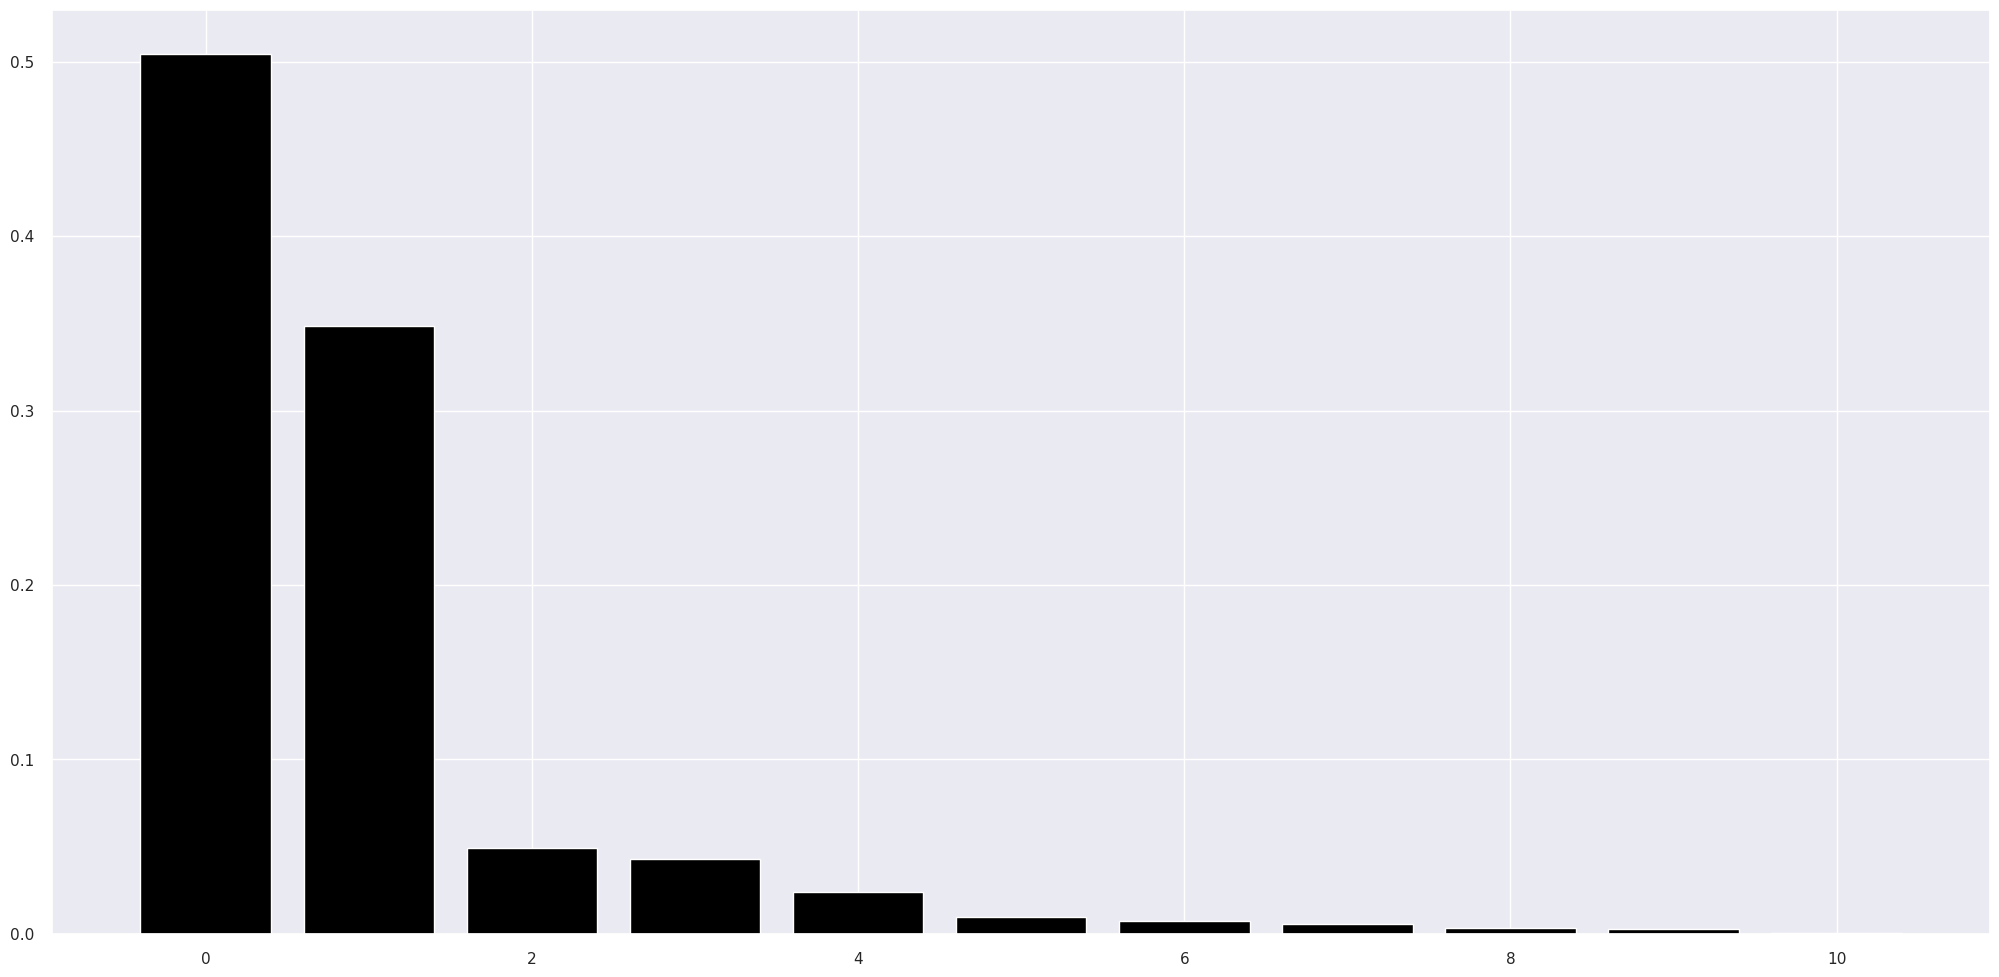

In [49]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_)

plt.bar( features, pca.explained_variance_ratio_, color='black')

# pca components
df_pca = pd.DataFrame( principal_components )

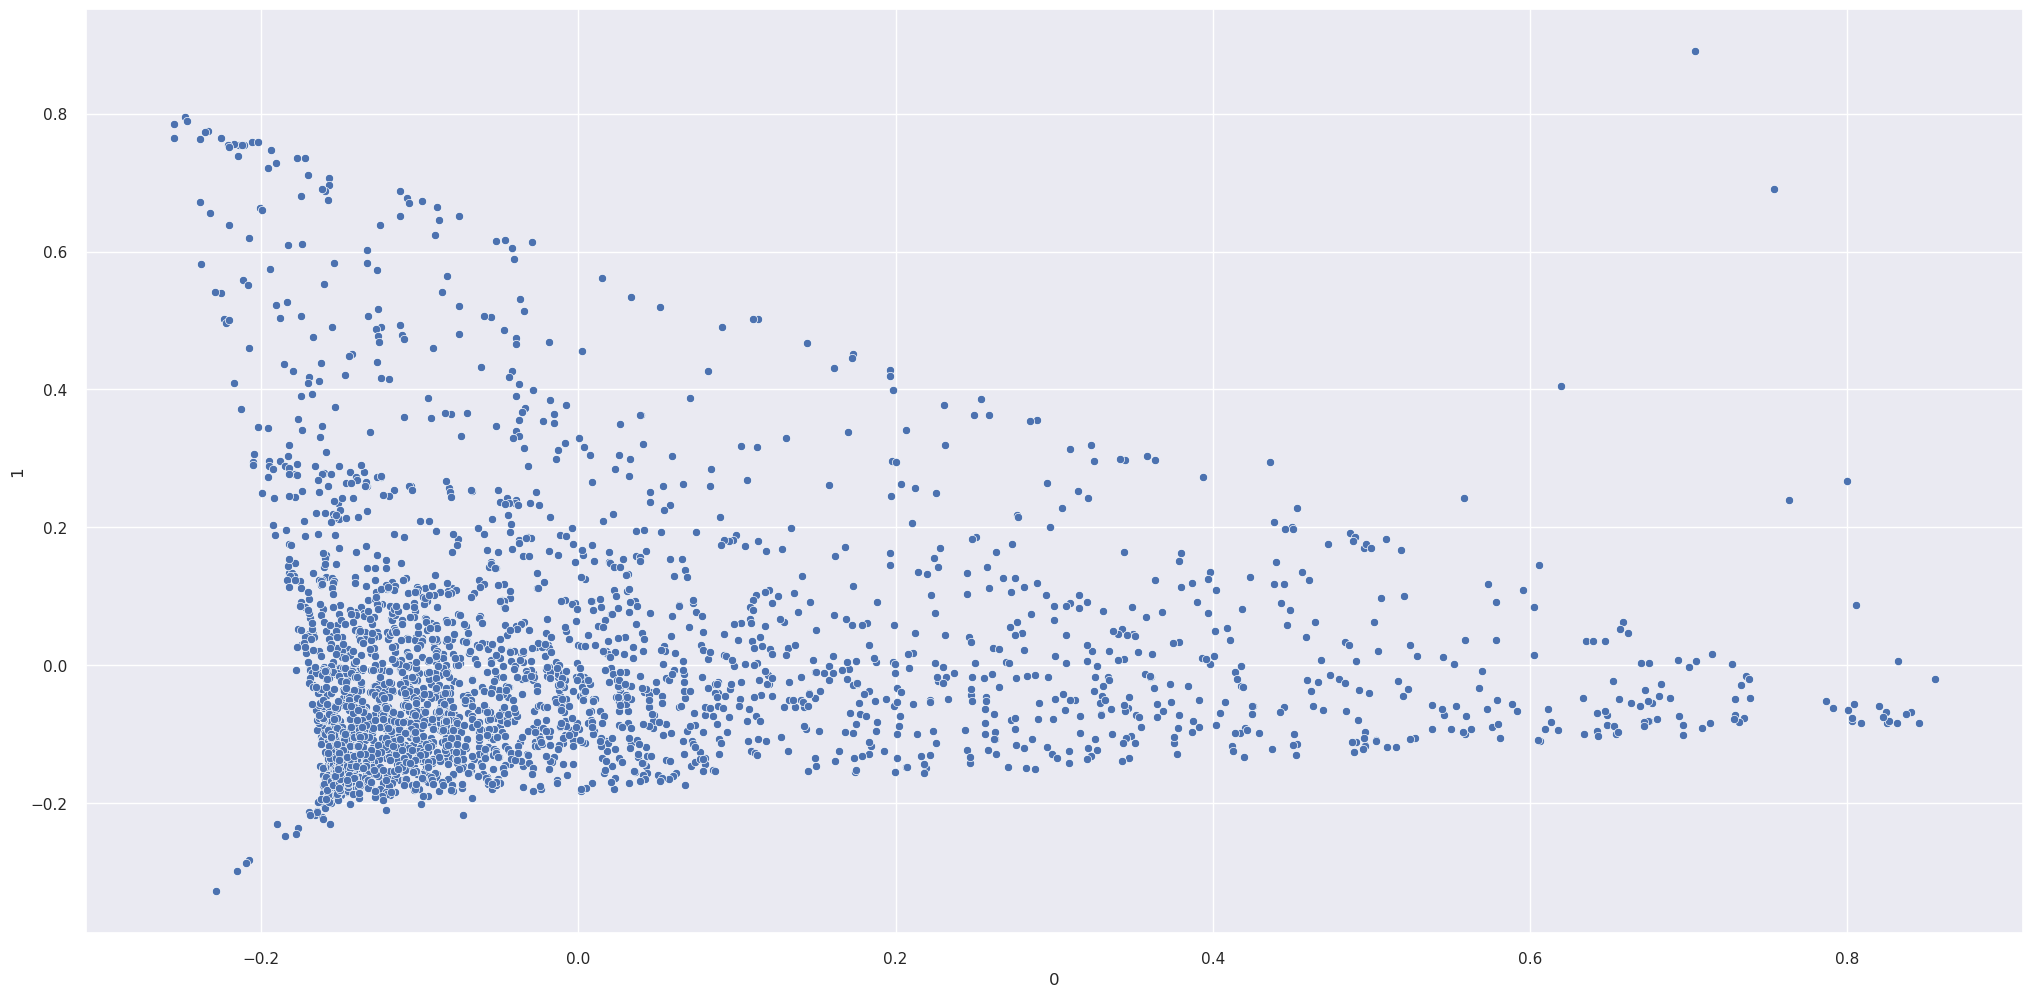

In [50]:
sns.scatterplot(x=0, y=1, data=df_pca);

#### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

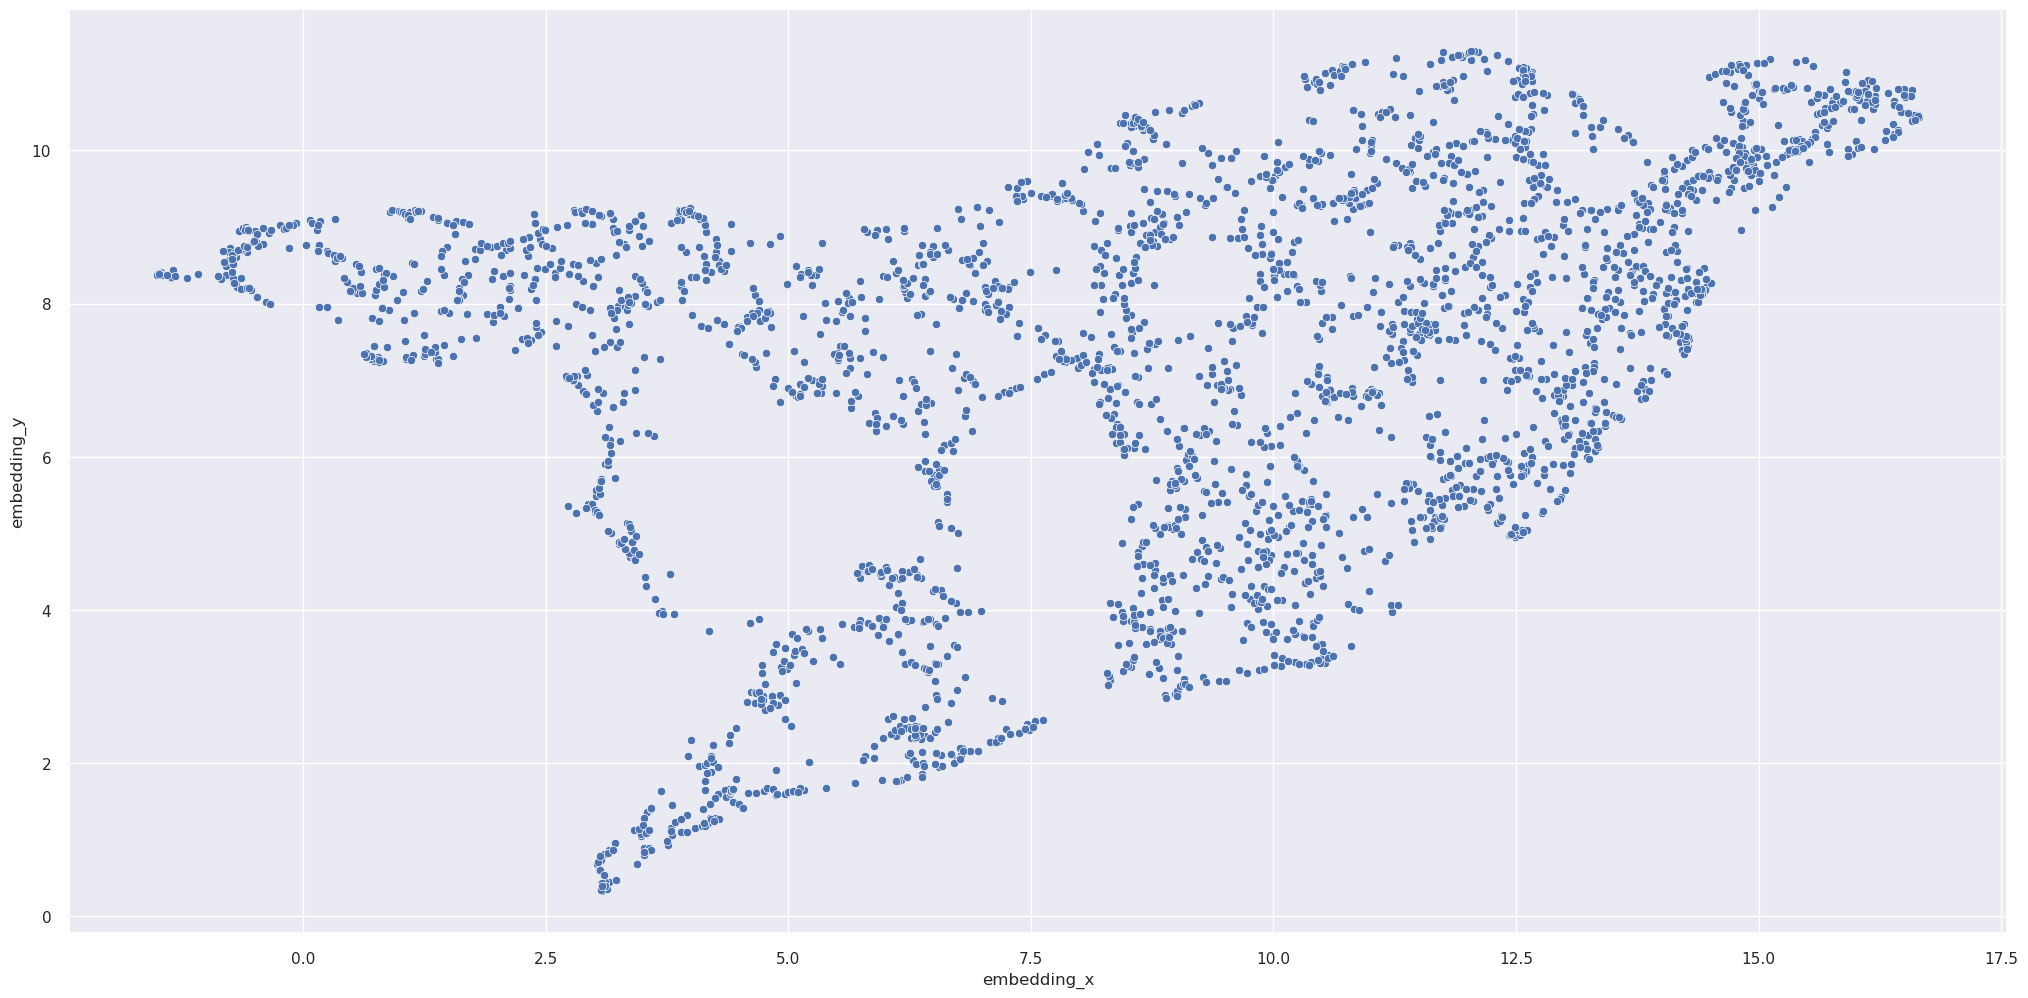

In [51]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# enbedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca)

#### 4.3.3 t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

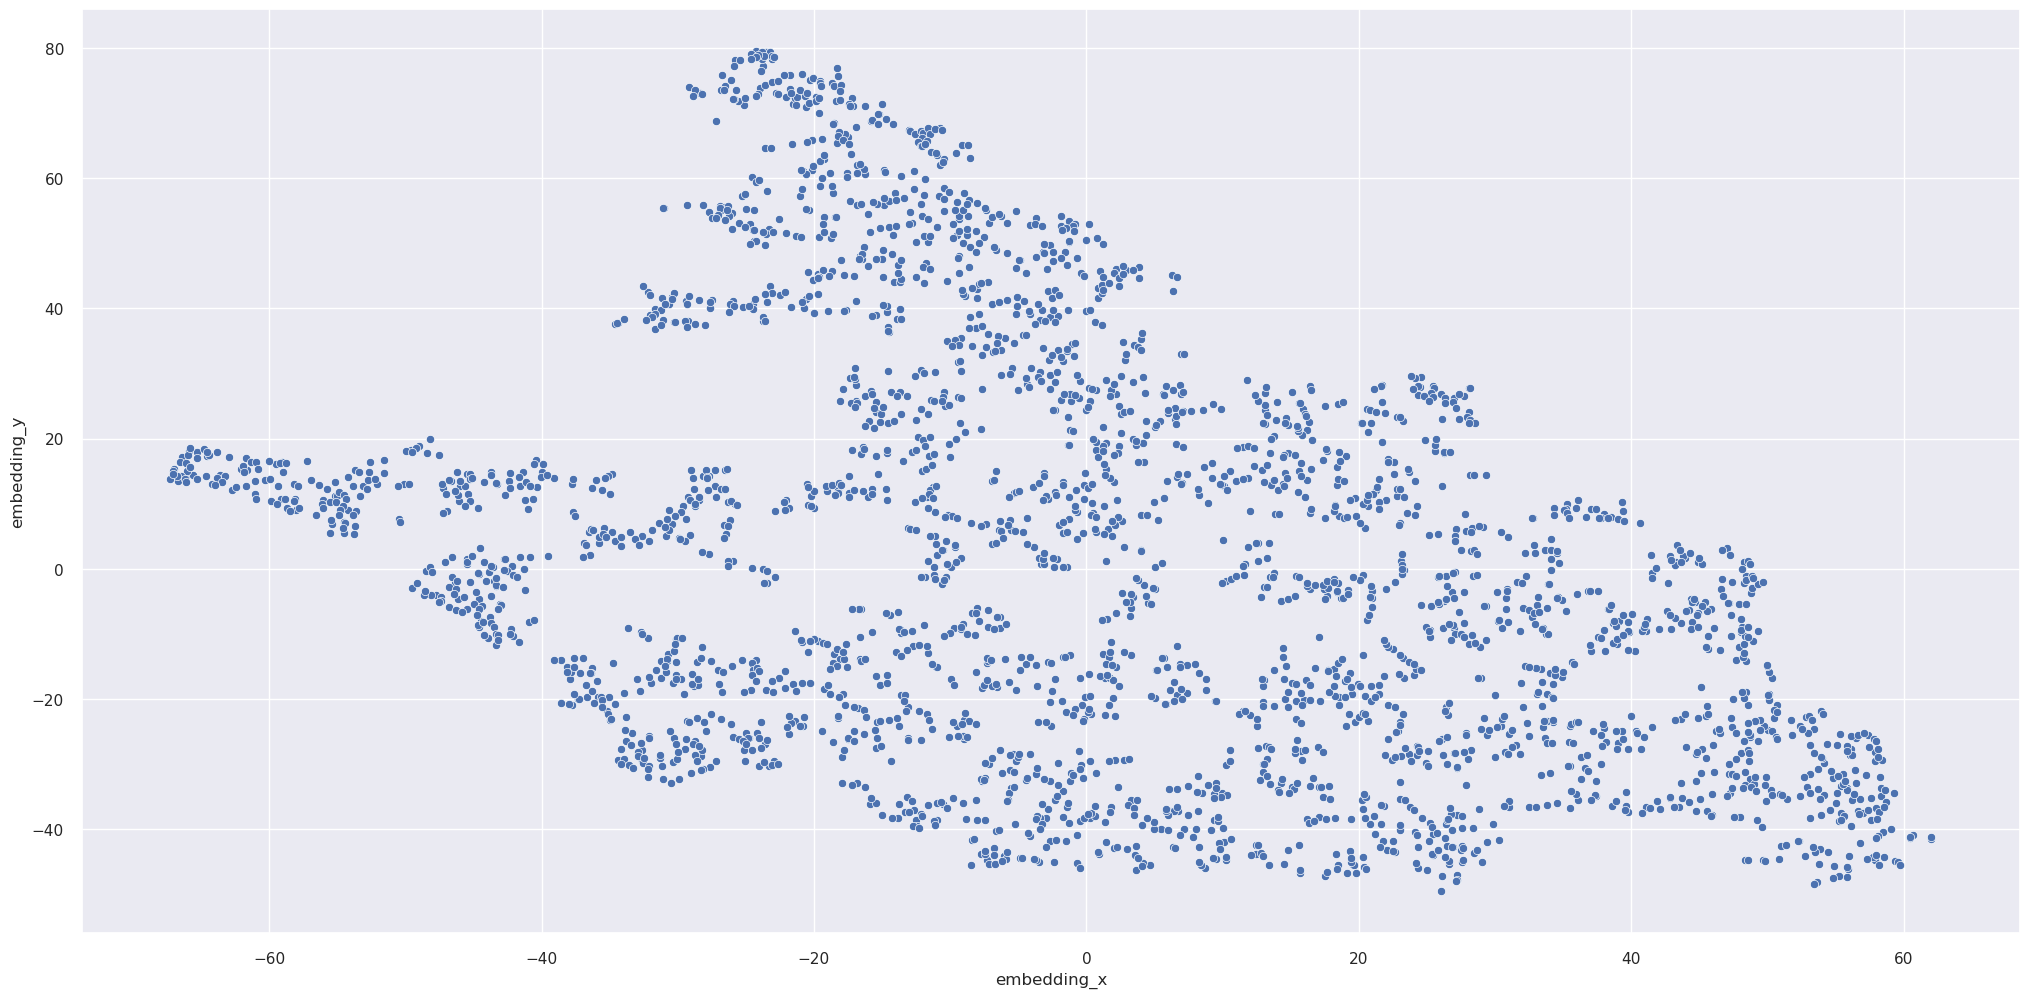

In [52]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# enbedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca)

#### 4.3.4 Tree-Based Embedding

In [53]:
# training dataset
X = df4.drop( columns=['customer_id','gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42)

# model training
rf_model.fit( X, y)

# Leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

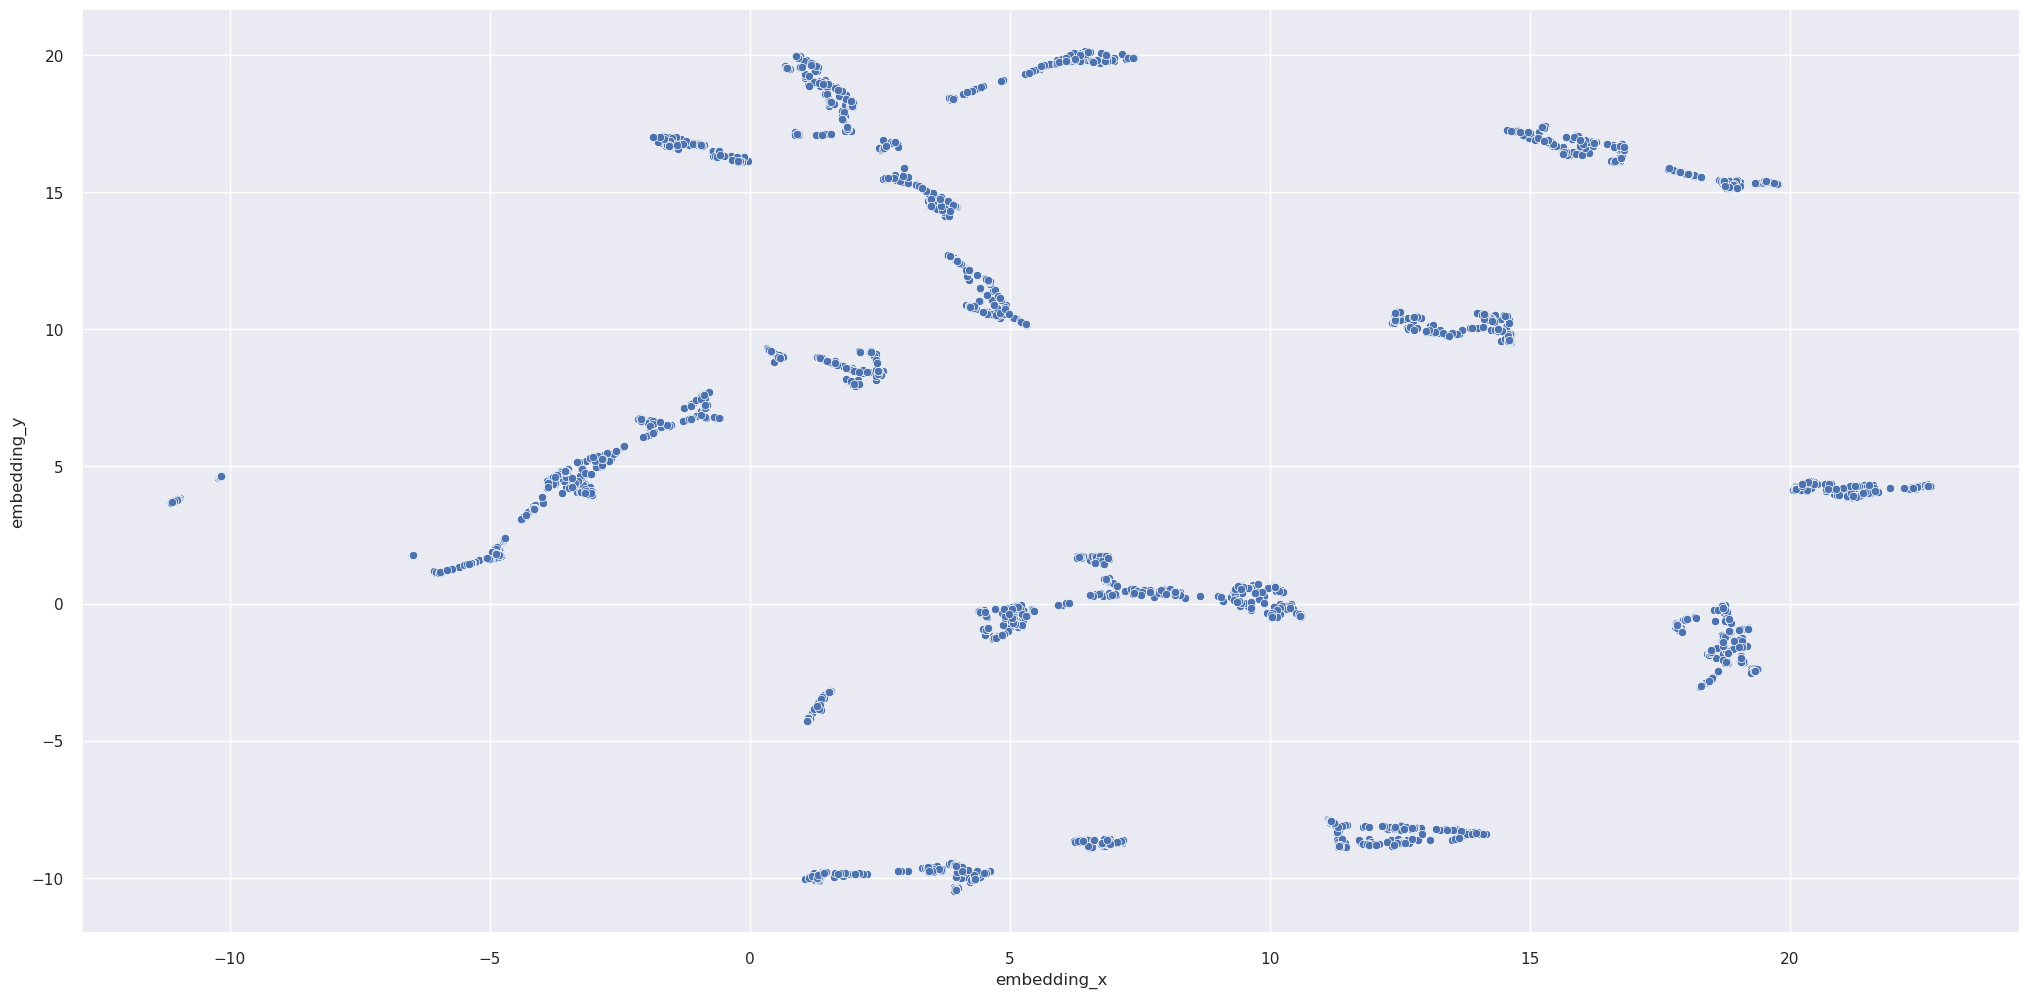

In [54]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# enbedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca)

## 5.0 Data Preparation

In [55]:
df5 = df4.copy()

In [56]:
df5.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtd_invoices',
       'qtd_items', 'qtd_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtde_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [57]:
# Standard Scaler
ss = pp.MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['qtd_invoices'] = ss.fit_transform(df5[['qtd_invoices']])
df5['qtd_items'] = ss.fit_transform(df5[['qtd_items']])
df5['qtd_products'] = ss.fit_transform(df5[['qtd_products']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = ss.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['qtde_returns'] = ss.fit_transform(df5[['qtde_returns']])
df5['avg_basket_size'] = ss.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = ss.fit_transform(df5[['avg_unique_basket_size']])

## 6.0 Feature Selection

In [58]:
df6 = df5.copy()

## 7.0 Hyperparameter Fine Tuning

In [59]:
x = df6.drop( columns=['customer_id'])

In [60]:
clusters = [2,3,4,5,6,7]

### 7.1 K-Means

In [61]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = cl.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(x)

    # model definition
    labels = kmeans_model.predict(x)

    # model performance
    sil = mt.silhouette_score( x, labels, metric='euclidean')
    kmeans_list.append(sil)

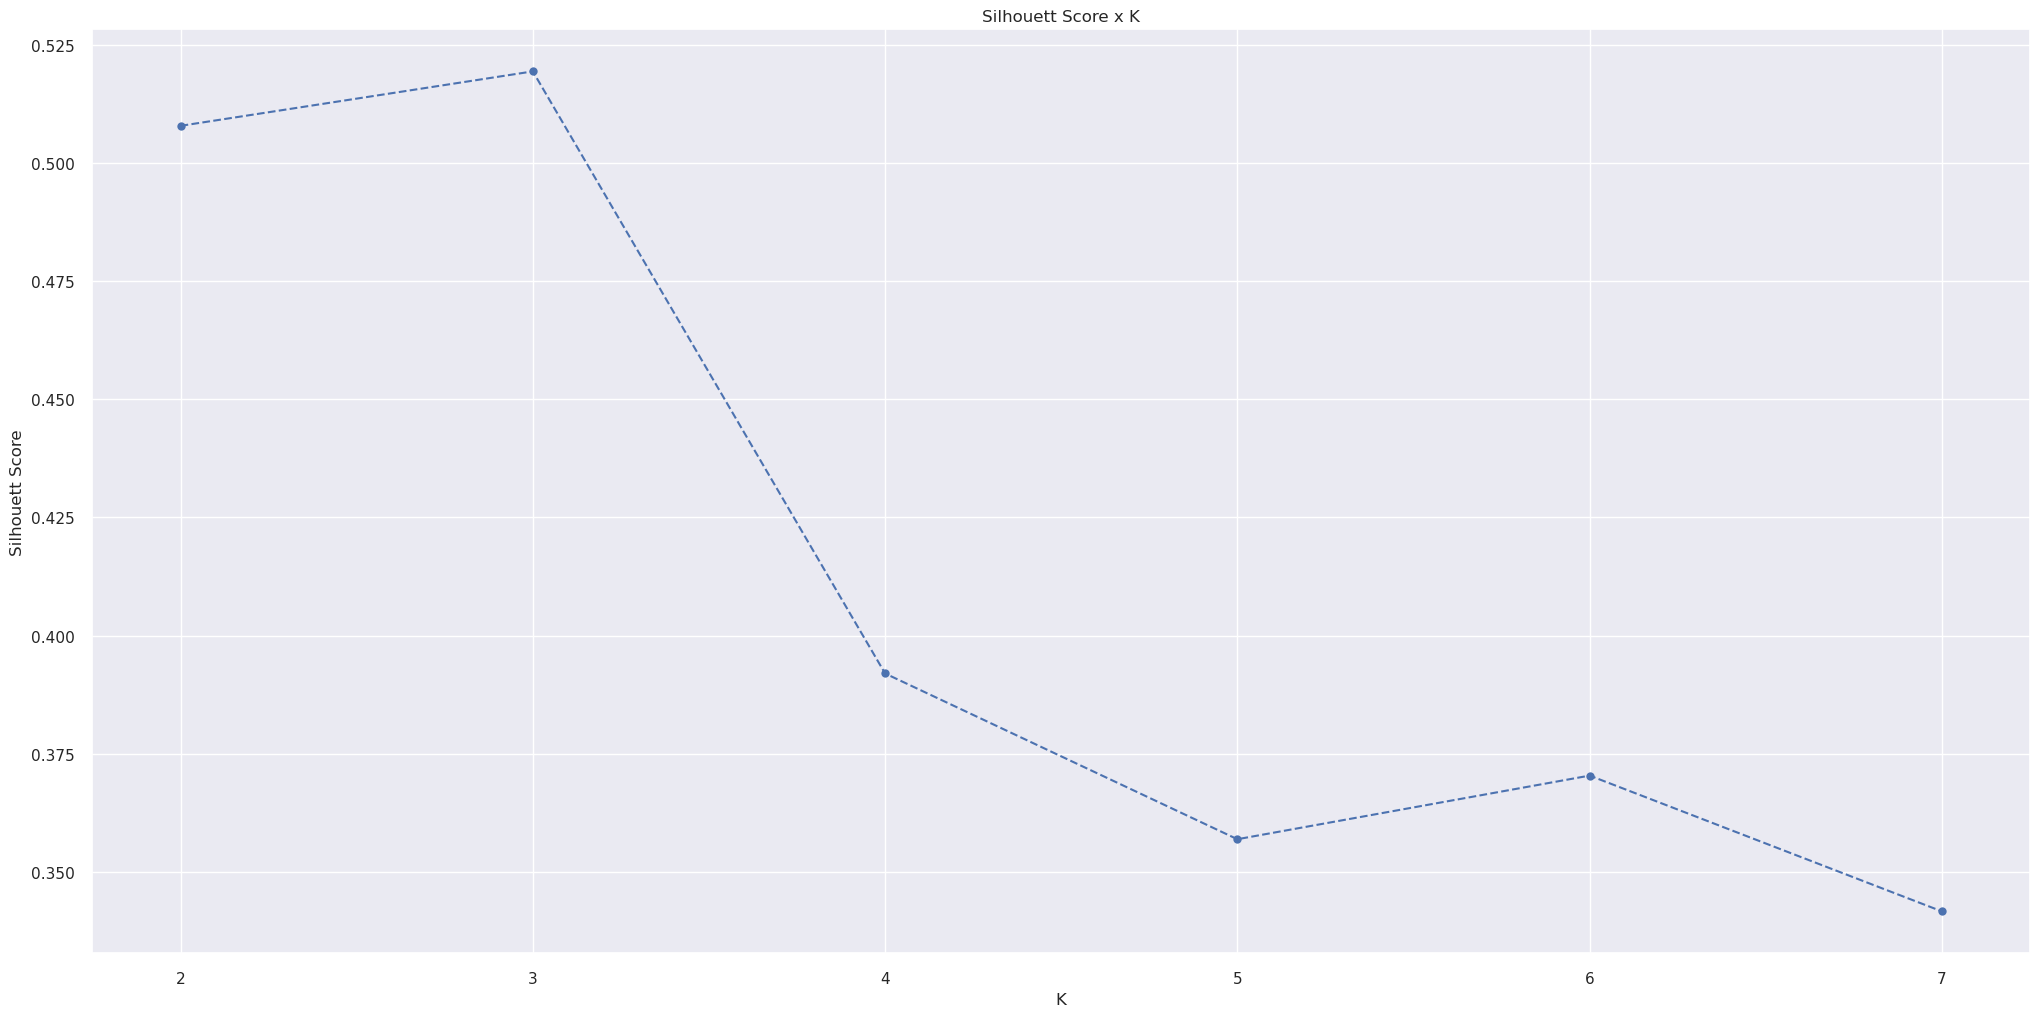

In [62]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouett Score');
plt.title('Silhouett Score x K');

### 7.2 GMM

In [63]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(x)

    # model definition
    labels = gmm_model.predict(x)

    # model performance
    sil = mt.silhouette_score( x, labels, metric='euclidean')
    gmm_list.append(sil)

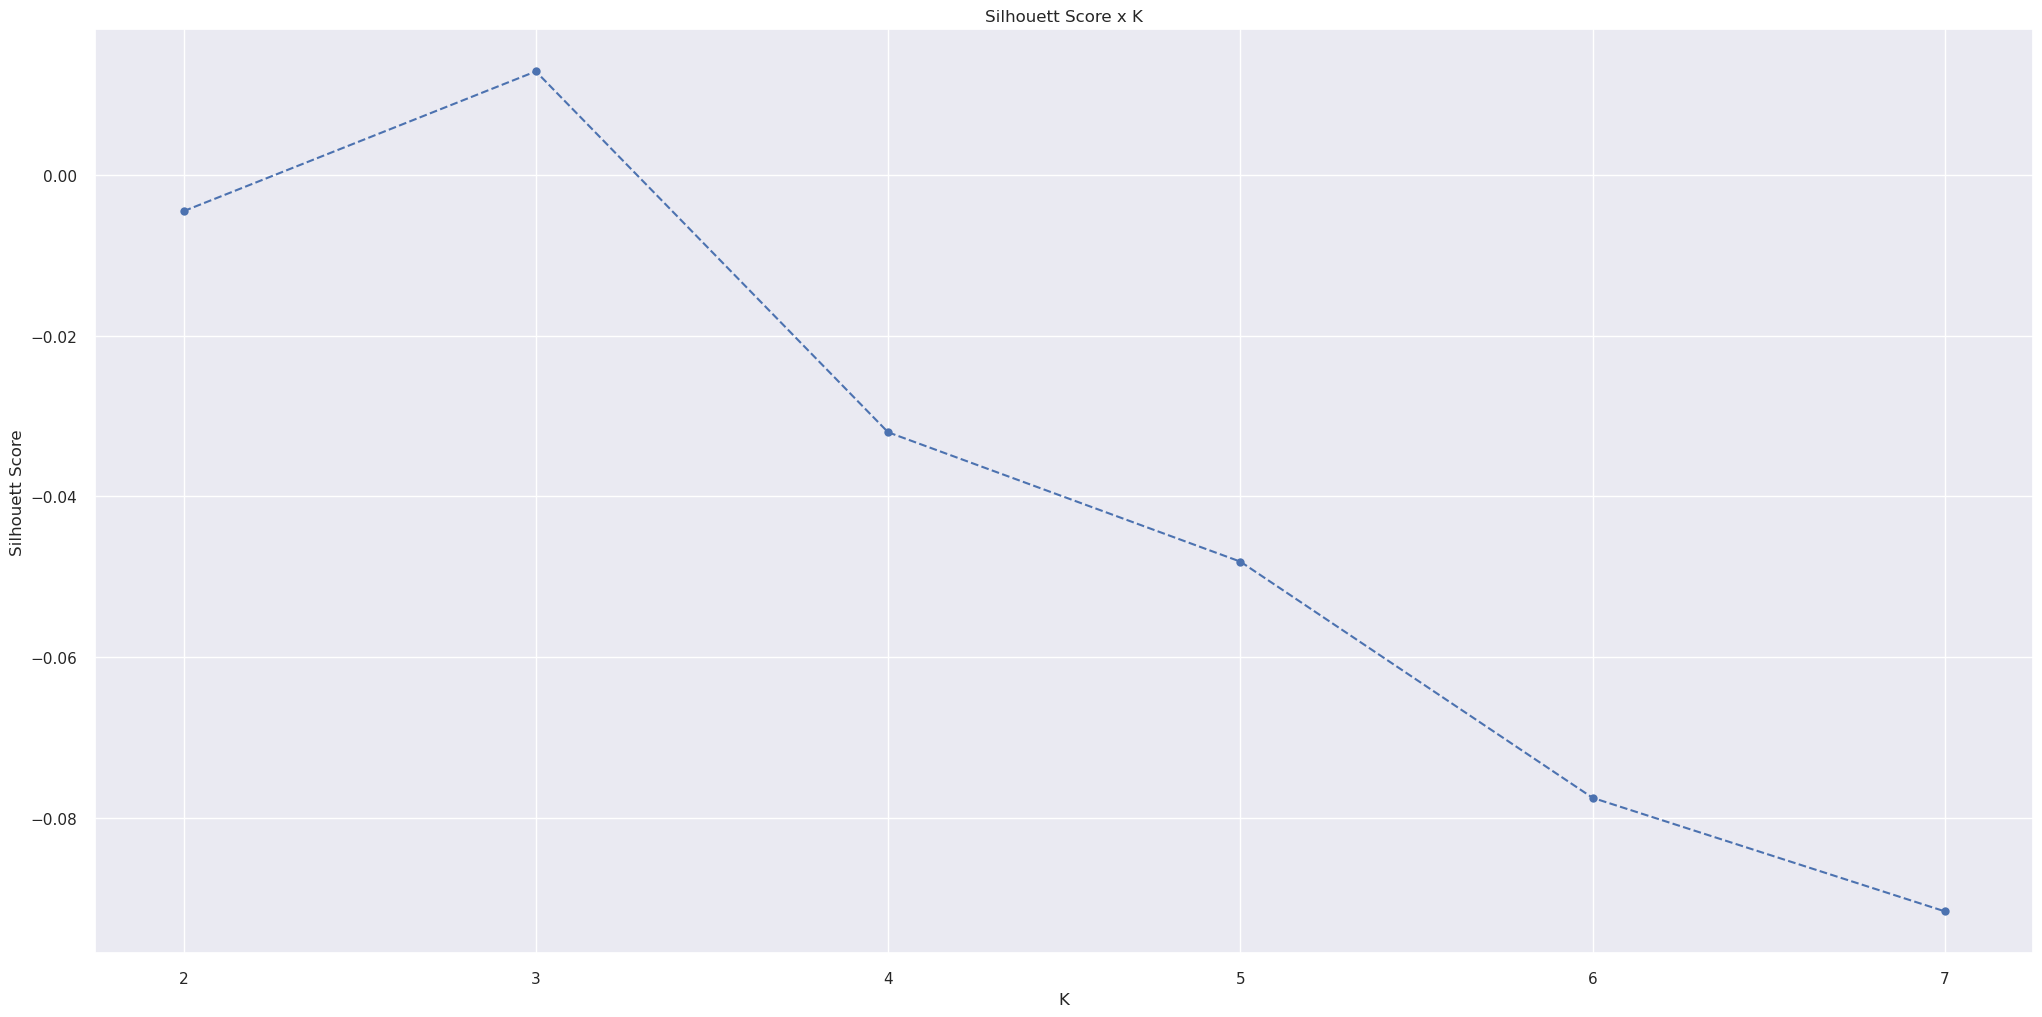

In [64]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouett Score');
plt.title('Silhouett Score x K');

### 7.3 Hierarchical Clustering

In [65]:
from scipy.cluster import hierarchy as hc

In [66]:
hc_model = hc.linkage( x, 'ward')

[]

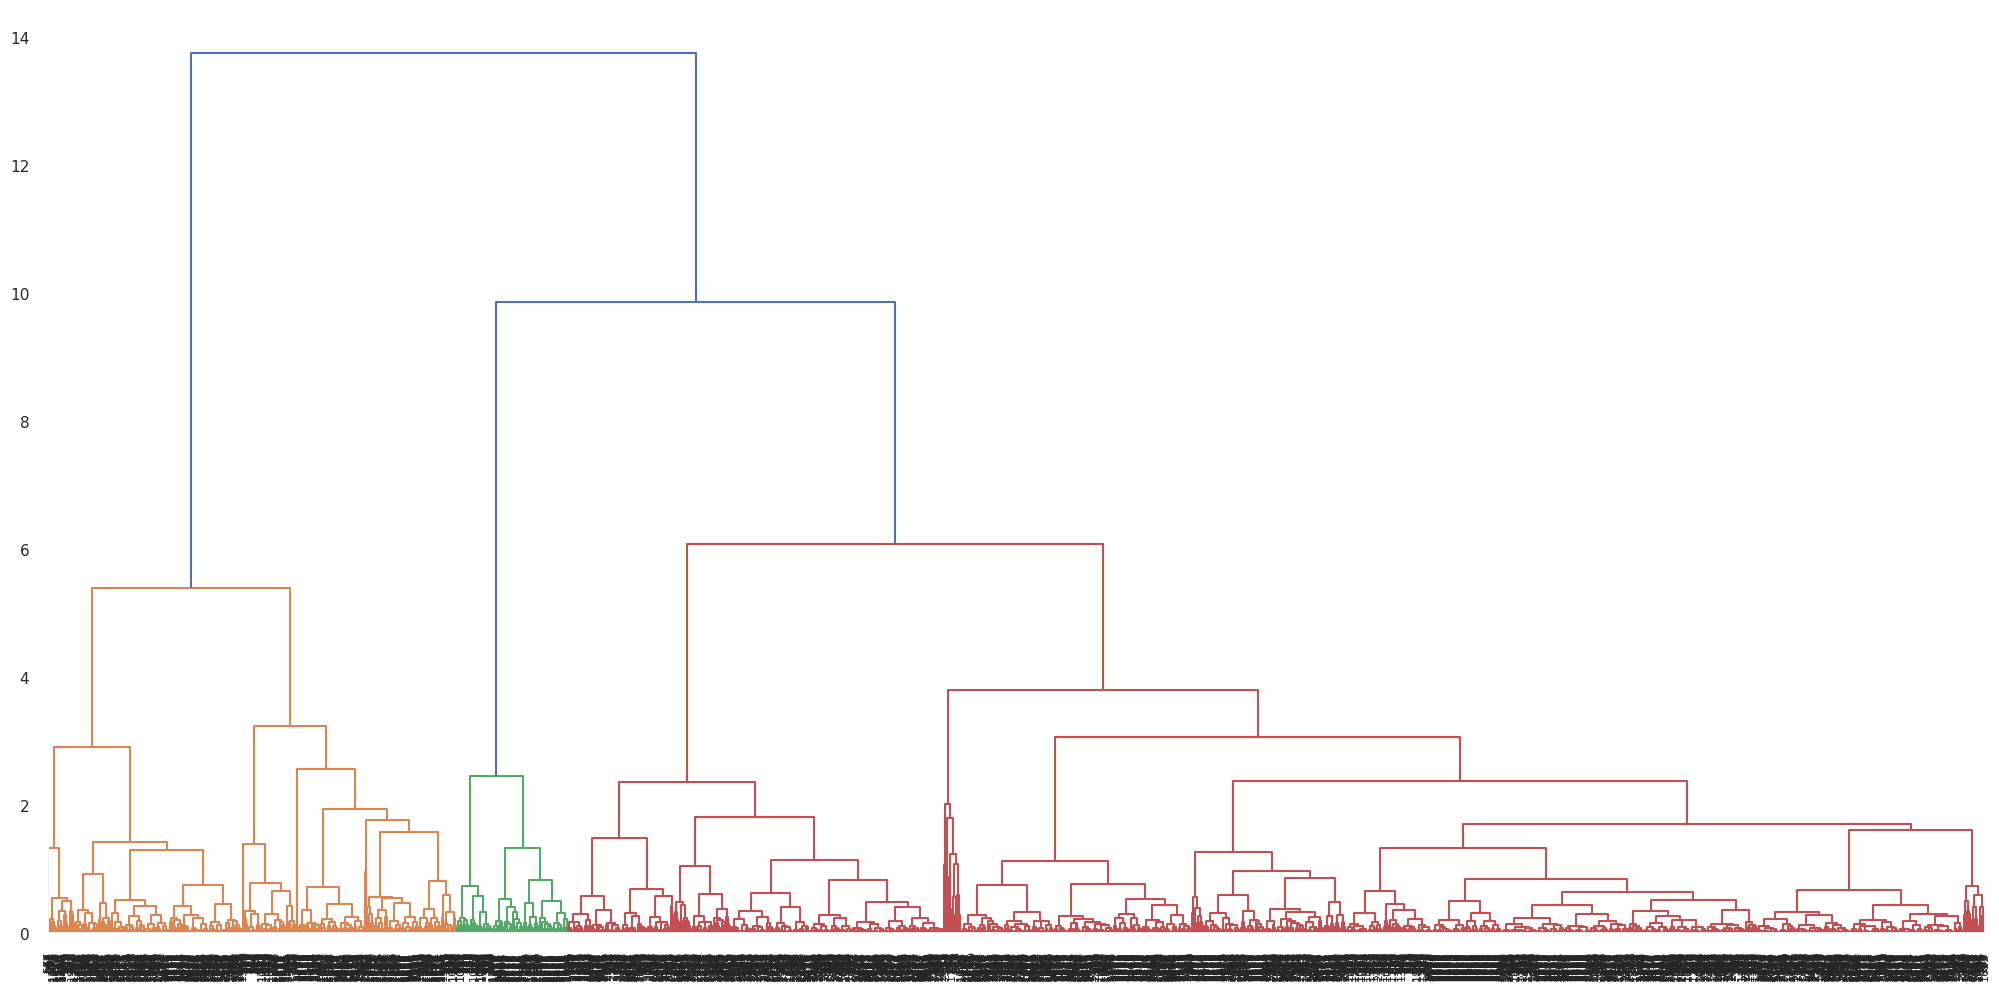

In [67]:
hc.dendrogram(
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8
)

plt.plot()

[]

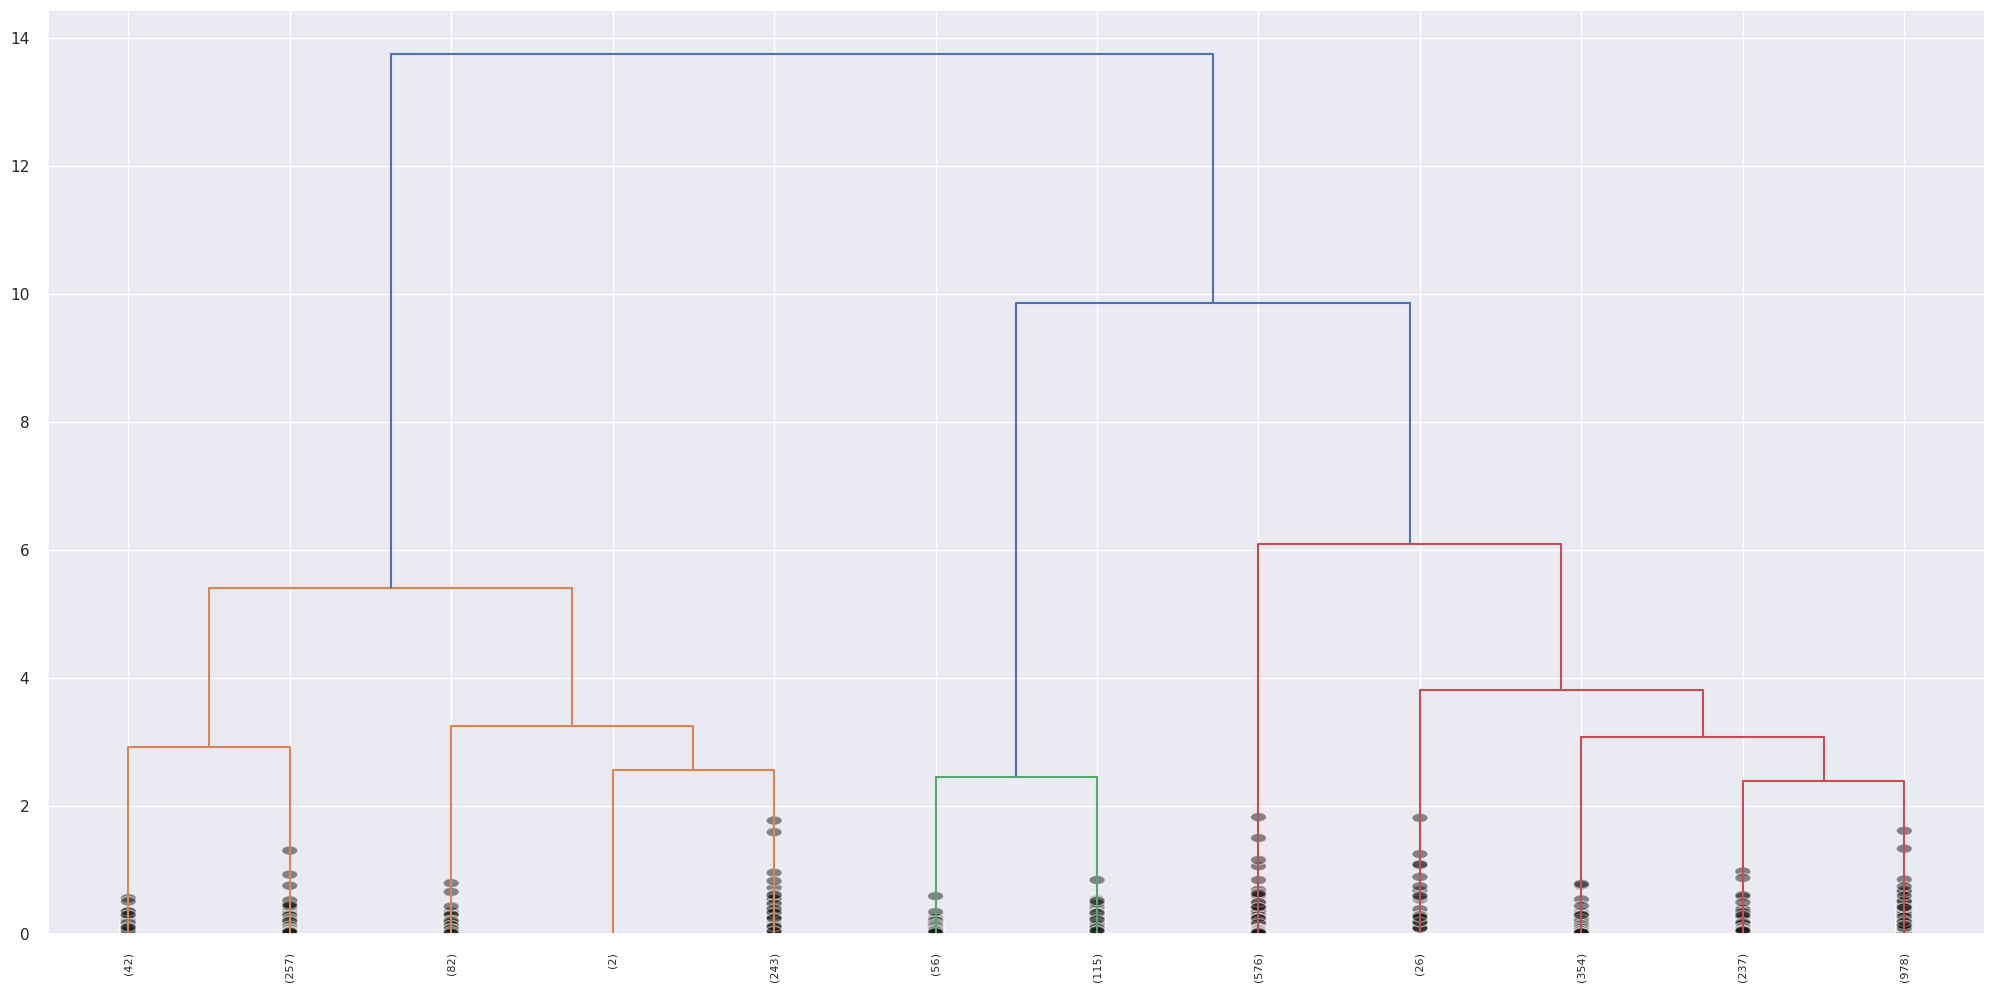

In [68]:
hc.dendrogram(
    hc_model,
    truncate_mode= 'lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.plot()

#### 7.3.1 HClustering SS

In [69]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(x, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # model performance
    sil = mt.silhouette_score( x, labels, metric='euclidean')
    hc_list.append(sil)

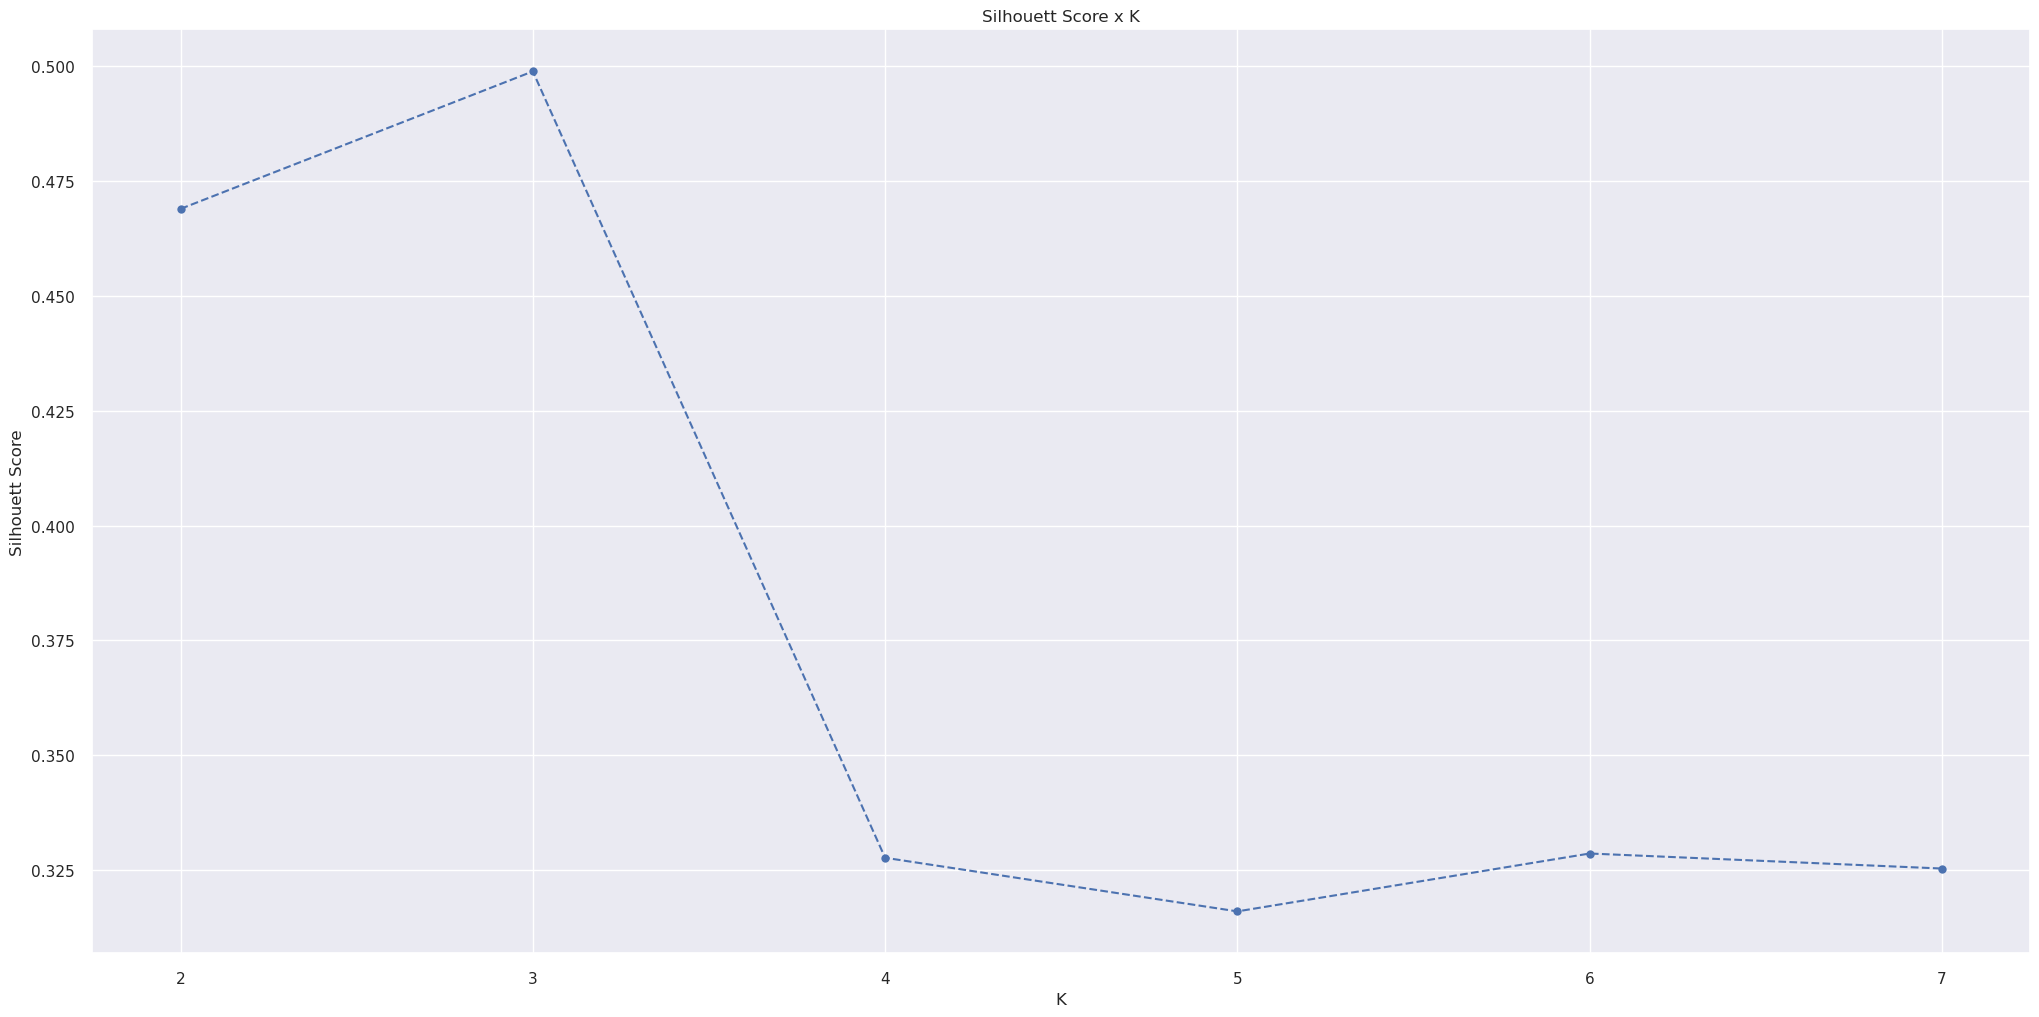

In [70]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouett Score');
plt.title('Silhouett Score x K');

### 7.4 DBSCAN

In [71]:
eps= 0.2
min_samples=20

# model definition
dbscan_model = cl.DBSCAN(eps=eps, min_samples=min_samples)

# model training & predict
labels = dbscan_model.fit_predict(x)

# model performance
sil = mt.silhouette_score( x, labels, metric='euclidean')
print( "Silhouette Score: {}".format( sil))
print( "Number of clusters: {}".format( len(np.unique(labels))))
print( np.unique(labels))


Silhouette Score: 0.622034827461325
Number of clusters: 2
[-1  0]


In [72]:
from sklearn.neighbors import NearestNeighbors

In [73]:
neighbors = NearestNeighbors( n_neighbors=min_samples).fit(x)
distances, indices = neighbors.kneighbors(x)

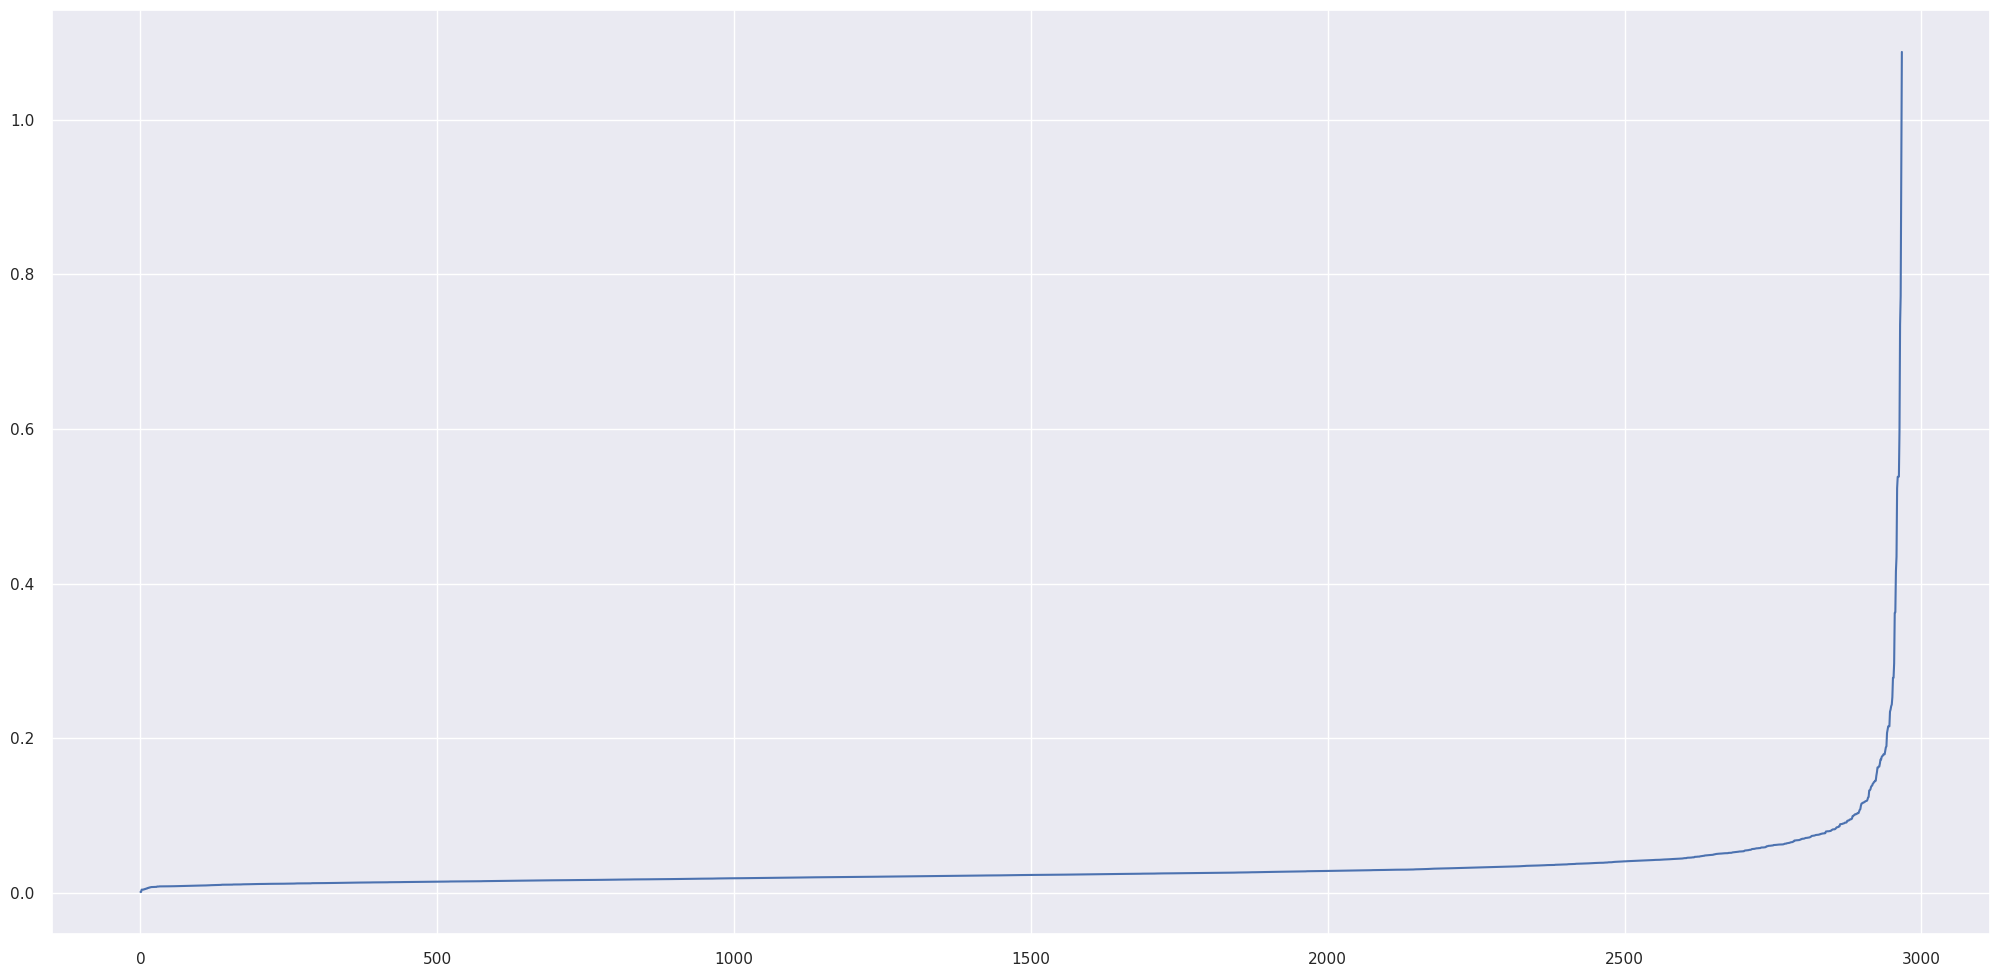

In [74]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot(distances);

In [75]:
dbscan_list = [0.622034,0.000000, 0.000000, 0.000000, 0.000000,  0.000000 ]

### 7.5 Results

In [76]:
df_results = pd.DataFrame(
        {'KMeans': kmeans_list,
         'GMM':gmm_list,
         'HClustering':hc_list,
         'DBSCAN':dbscan_list}).T

df_results.columns = clusters

In [77]:
df_results.style.highlight_max( color='green', axis=1)

,2,3,4,5,6,7
KMeans,0.507904,0.519431,0.391971,0.356885,0.370355,0.341608
GMM,-0.004519,0.012877,-0.032032,-0.048131,-0.077524,-0.091655
HClustering,0.468911,0.498824,0.327713,0.316046,0.328641,0.325372
DBSCAN,0.622034,0.000000,0.000000,0.000000,0.000000,0.000000


 For K = 2. Silhouette Score: 0.4689113070295039
 For K = 3. Silhouette Score: 0.49882430497442565
 For K = 4. Silhouette Score: 0.32771315437908355
 For K = 5. Silhouette Score: 0.3160463752933211
 For K = 6. Silhouette Score: 0.3286405694813848
 For K = 7. Silhouette Score: 0.3253720291762707


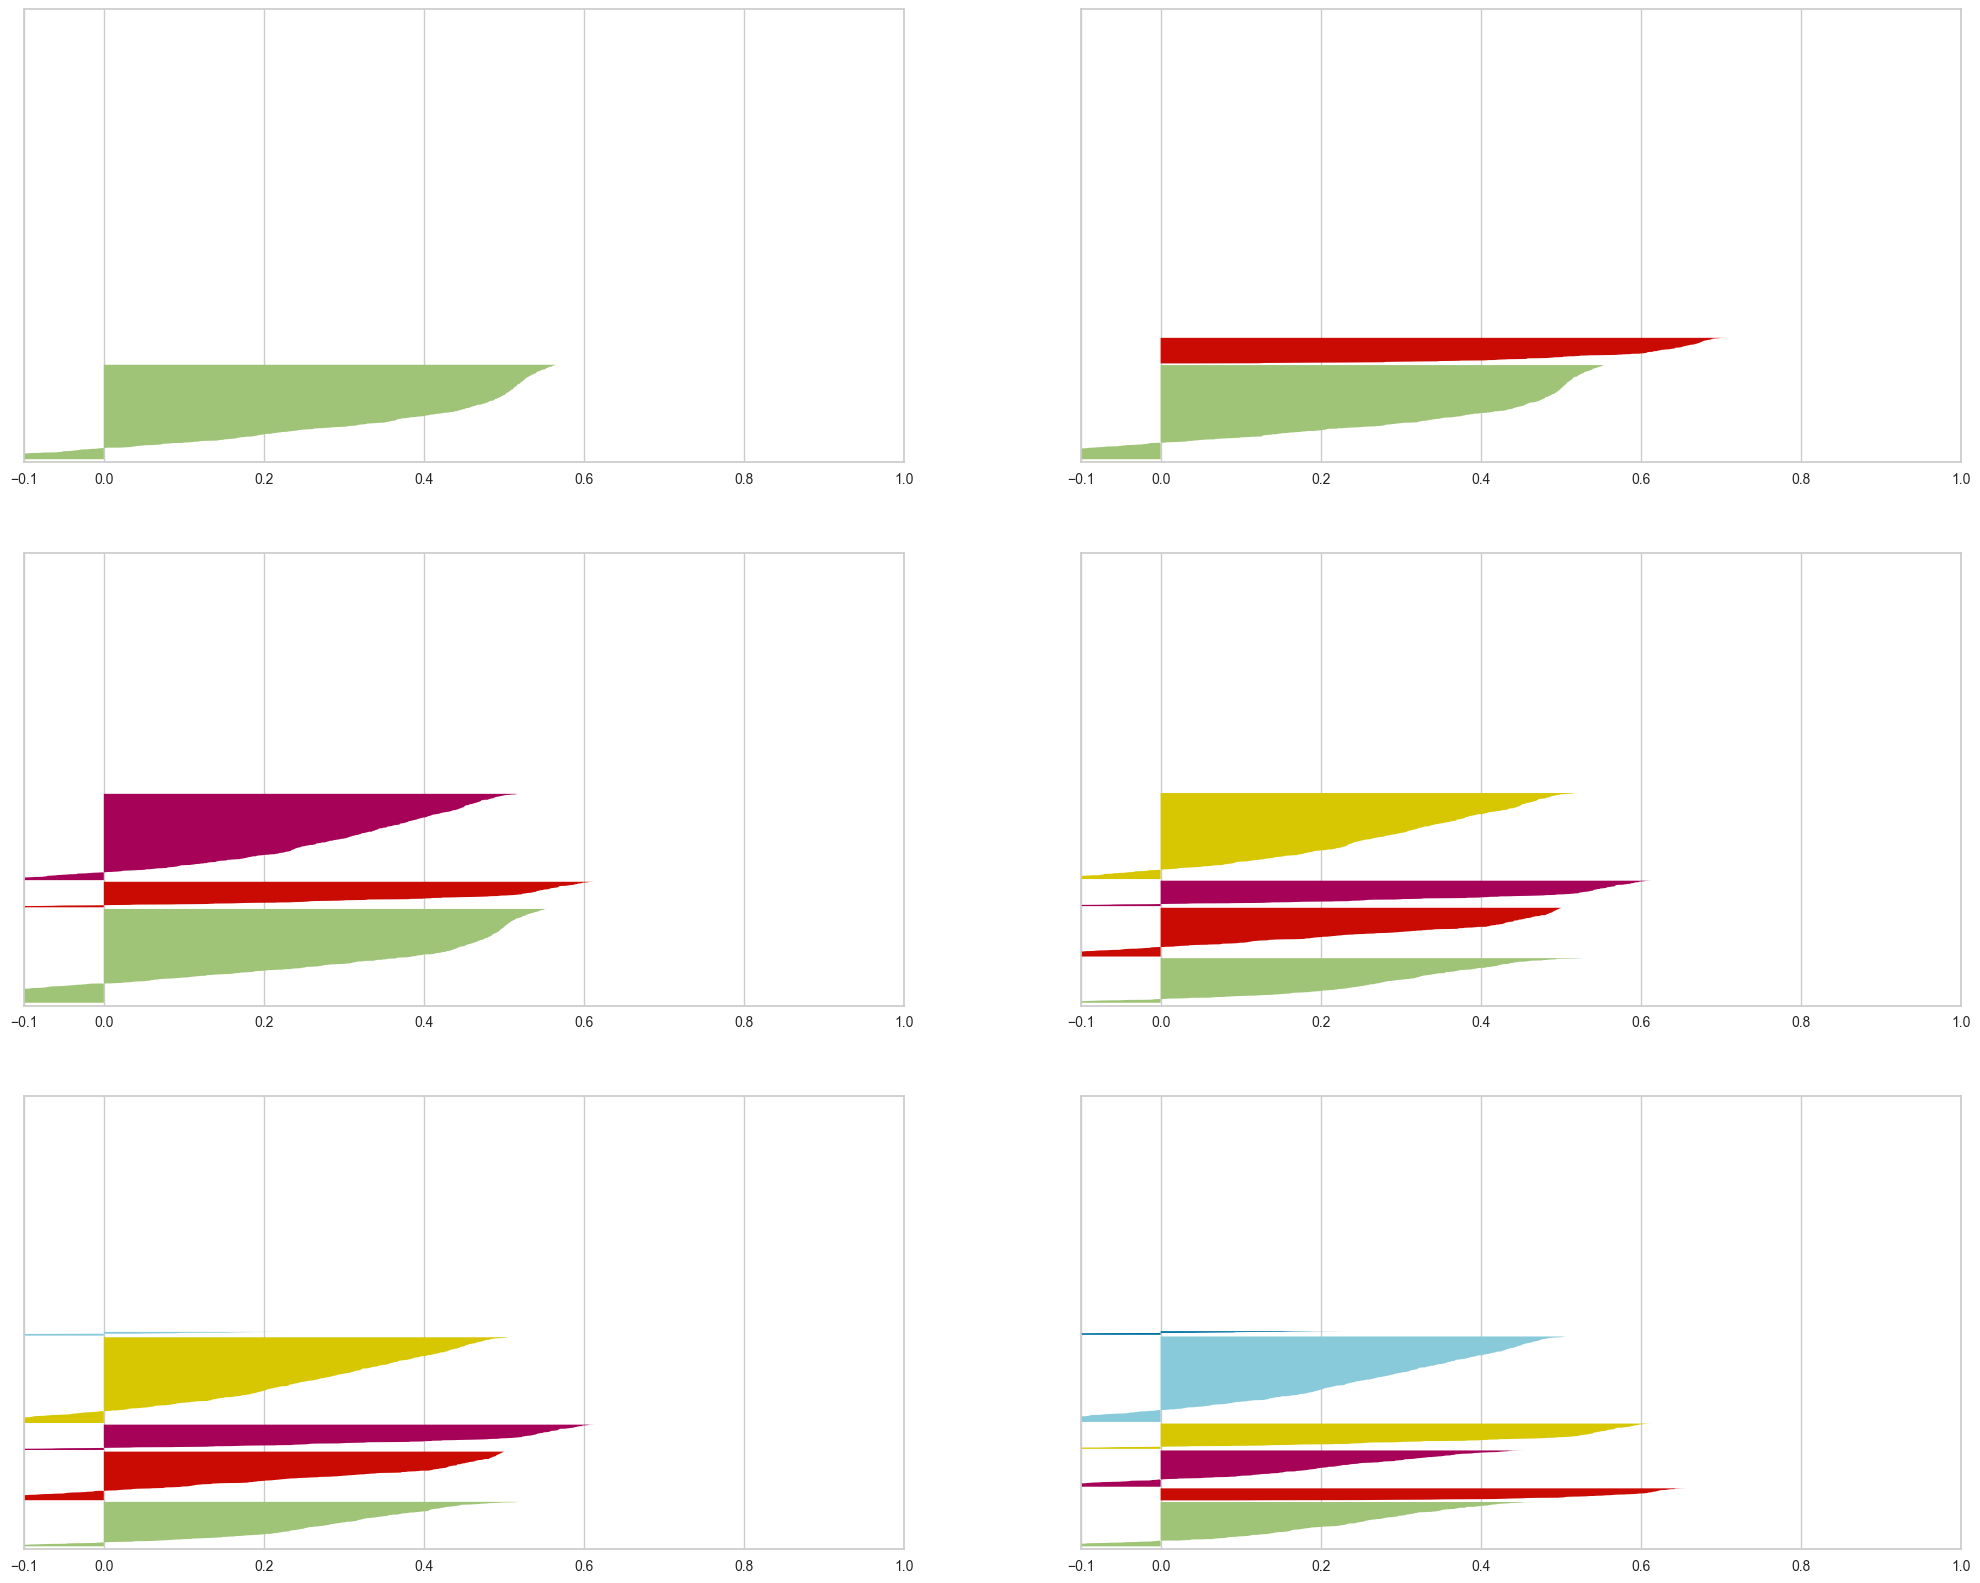

In [106]:
#Using with HC here:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    #position to plot
    q, mod = divmod( k, 2 )
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( x ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( x, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = mt.silhouette_score( x, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    #get silhouette values of each sample
    samples_silhouette_values = mt.silhouette_samples( x, labels )

    #space between clusters
    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # define colors range
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k ) 

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## 8.0 Model Training

### 8.1 K-Means

In [ ]:
# model definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(x)

# clustering
labels = kmeans.labels_

#### 8.1.2 Cluster validation

In [ ]:
# WSS
print('WSS value: {}'.format(kmeans.inertia_))

# SS
print('SS value: {}'.format(mt.silhouette_score(x, labels, metric='euclidean')))


## 9.0 Cluster Analysis

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels

### 9.1 Visualization Inspection

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(x)
visualizer.finalize()

### 9.2 2d Plot

In [ ]:
df_viz = df9.drop(columns='customer_id',axis=1)
# sns.pairplot(df_viz, hue='cluster')

### 9.3 UMAP 

In [ ]:
reducer = umap.UMAP(n_neighbors=20 ,random_state=42)
embedding = reducer.fit_transform(x)

# enbedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len( df_viz['cluster'].unique())),
                data=df_viz)

### 9.4 Cluster profile

In [ ]:
# number of customer
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum()),2)

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster,df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency_days
df_avg_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster,df_avg_recency_days, how='inner', on='cluster')

# Avg frequency
df_avg_frequency = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster,df_avg_frequency, how='inner', on='cluster')

# Avg ticket
df_avg_ticket= df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster,df_avg_ticket, how='inner', on='cluster')



df_cluster

## 10.0 Deploy to Production